In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.model_selection import train_test_split

In [2]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)        
        self.n_batches = n_batches
    
    
    #---------------------------------
    def forward(self, X):
        # умножаем признаки на веса
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        # расчет функции потерь
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        # расчет градиента
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        # обновление весов
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        # инициализируем веса
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        # делем предсказание модели
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):    
        # оценка по коэффициенту детерминации     
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):
        # обучение модели с учетом разбиения на батчи
        np.random.seed(self.seed)

        if self.weights is None: # если веса не заданы - задаем
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: # если смещение не задано - задаем
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]: # если веса заданы, но не добавлено смещение - объединяем 
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:   # проверка на согласование размерности батча и размерности данных         
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): #циклы обучения, как раньше
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        # загрузка батча
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch) # тут мы всегда добавляем смещение
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        # добавление смещения
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        # отрисовка сразу в методе
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        # "новый" метод - который возвращает веса модели и смещение
        return (self.weights[1:], self.bias)

In [3]:
class ElasticRegression(LinearRegression): #унаследуем всё что можно от "базовой" модели
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 n_batches    = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
        
    #---------------------------------
    def loss(self,yhat, y):   
        # изменяем функцию потерь 
        l1_term = self.l1_penalty*np.sum(np.abs(self.weights[1:]))
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    #---------------------------------
    def update(self):    
        # изменяем правило обновление весов 
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

In [4]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для классификации   
    Входные переменные:
    ===========
    ax: 
    ds: набор данных, содержащий признаки X и целевые метки y
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """
    
    X, y = ds # распаковываем признаки и целевые метки в отдельные переменные

    cm_bright = ListedColormap(colors) # формируем цветовую карту из наших цветов
    ax.set_title(name, fontsize = 30) # прописываем название графика
    if facecolor: # если переменная задана - то просто рисуем скатерограмму по признакам с использованием параметров маркеров
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else: # иначе так же рисуем скатерограмму, но без
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
    # немного красоты и ля аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [5]:
def make_binary_clf(N, method = 'line', noises = 0.15, random_state = 42):
    """Создание синтетического набора данных 
    для бинарной классификации   
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных 
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    if random_state: rng = np.random.RandomState(seed = random_state)
    
    if method == 'line' or method is None:
        X, y = make_classification(n_samples=N, 
                                   n_features=2, 
                                   n_redundant=0, 
                                   n_informative=2,
                                   n_clusters_per_class=1, 
                                   class_sep=2, 
                                   random_state=random_state 
                                   )
        X += np.random.randn(*X.shape) *noises 
    
    elif method == 'moons':
        X, y = make_moons(n_samples=N, 
                          noise=noises, 
                          random_state=random_state 
                          )
    
    elif method == 'circles':  
        X, y = make_circles(n_samples=N, 
                            noise=noises, 
                            factor=0.5, 
                            random_state=random_state 
                            )
    
    return X,y

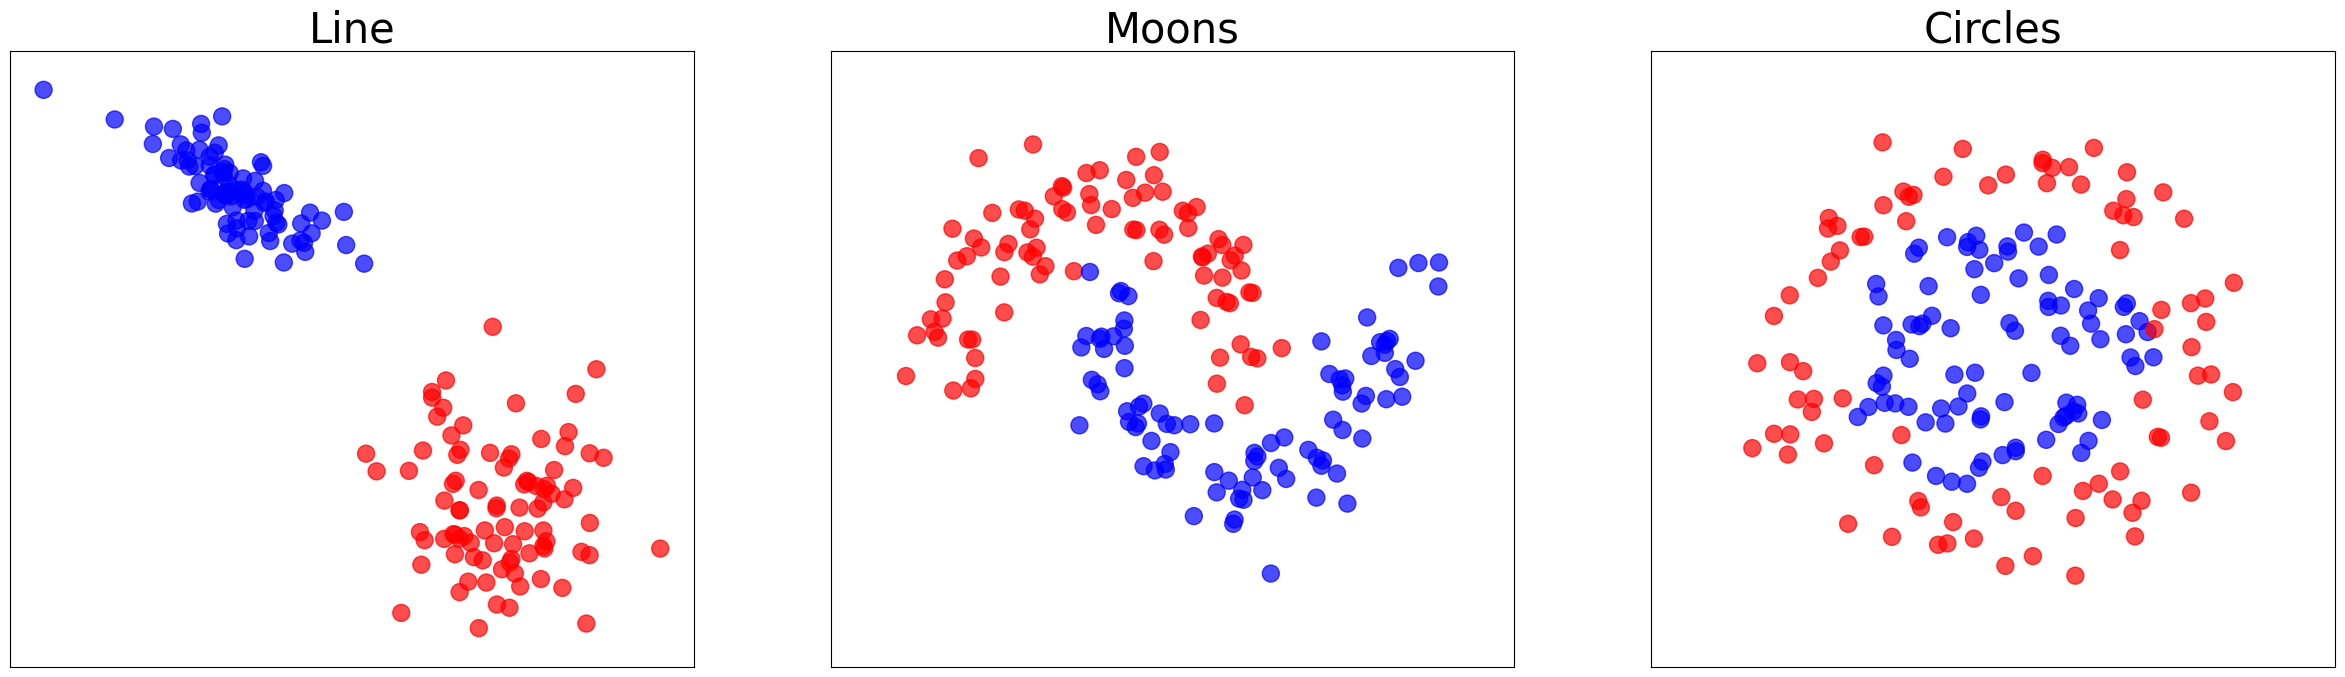

In [6]:
#@title Data { run: "auto" }
N = 175 #@param {type:"slider", min:50, max:250, step:25}
noises = 0.5 #@param {type:"slider", min:0, max:1, step:0.05}
random_state = 33

fig=plt.figure(figsize=(30,8))

ax = plt.subplot(1, 3, 1)
plot_data(ax,make_binary_clf(N,method = 'line', random_state=random_state),
          'Line')
ax = plt.subplot(1, 3, 2)
plot_data(ax,make_binary_clf(N,method = 'moons', random_state=random_state), 
          'Moons')
ax = plt.subplot(1, 3, 3)
plot_data(ax, make_binary_clf(N,method = 'circles', random_state=random_state),
          'Circles')

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)) 

In [8]:
def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z)) 

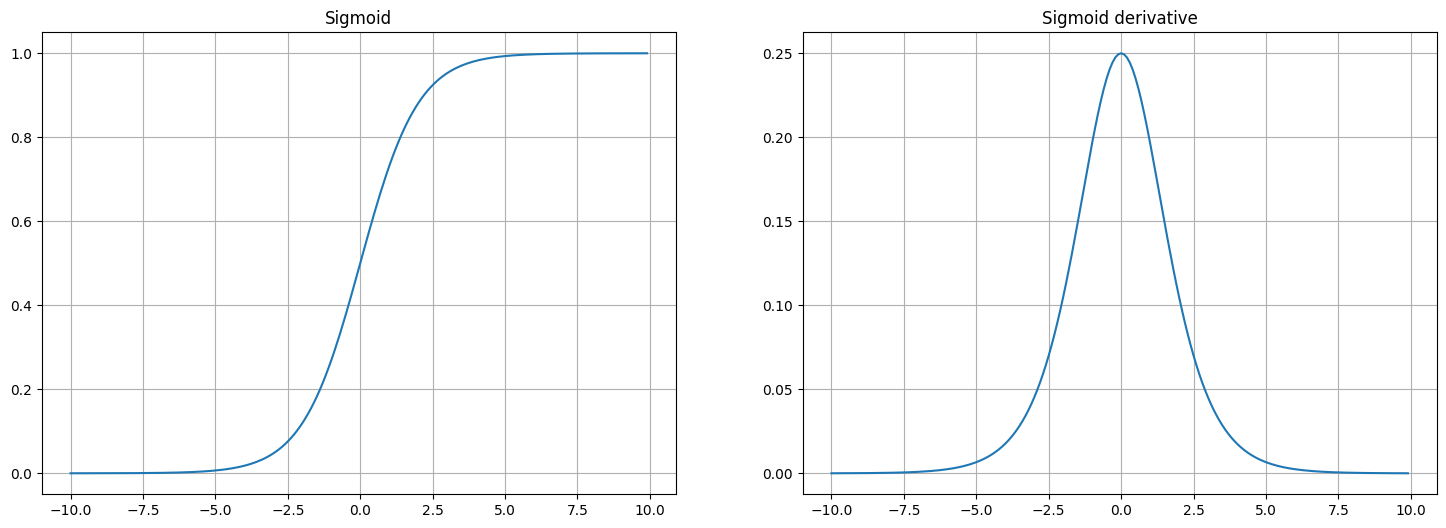

In [9]:
z = np.arange(-10,10,0.1)

plt.figure(figsize=(18,6))
plt.subplot(121); 
plt.plot(z,sigmoid(z)); plt.title('Sigmoid')
plt.grid()
plt.subplot(122); 
plt.plot(z,sigmoid_derivative(z)); plt.title('Sigmoid derivative')
plt.grid()

In [10]:
def to_class(logit, threshold = 0.7):
    return (logit >= threshold) * 1

In [11]:
print( to_class(sigmoid(0.5), threshold = 0.6), ',',  to_class(sigmoid(-2.5), threshold = 0.7) , ',', to_class(sigmoid(2), threshold = 0.8))

1 , 0 , 1


In [12]:
_EPS_ = 1e-6
def bce_loss(yhat, y):
    return -(y*np.log(yhat + _EPS_)+(1 - y)*np.log(1 - yhat + _EPS_)).mean()

In [13]:
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):\t %.3f' % bce_loss(yhat=0.5, y=1))
print('Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):\t %.3f' % bce_loss(yhat=0.5, y=0))
print('Правильно предсказываем 0 класс (yhat=0, y=0):\t %.3f' % bce_loss(yhat=0.0, y=0))
print('Правильно предсказываем 1 класс (yhat=1, y=1):\t %.3f' % bce_loss(yhat=1, y=1))
print('Неправильно предсказываем 0 класс (yhat=0, y=1):\t %.3f' % bce_loss(yhat=0.0, y=1))
print('Неправильно предсказываем 1 класс (yhat=1, y=0):\t %.3f' % bce_loss(yhat=1, y=0))

Неопределенность - попали ровно в 0.5 (yhat=0.5, y=1):	 0.693
Неопределенность - попали ровно в 0.5 (yhat=0.5, y=0):	 0.693
Правильно предсказываем 0 класс (yhat=0, y=0):	 -0.000
Правильно предсказываем 1 класс (yhat=1, y=1):	 -0.000
Неправильно предсказываем 0 класс (yhat=0, y=1):	 13.816
Неправильно предсказываем 1 класс (yhat=1, y=0):	 13.816


In [14]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T

In [15]:
class LogisticRegression(ElasticRegression):  
    # унаследуем всё что можно от модели линейной регрессии с эластичной регуляризацией
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias = None, 
                 threshold = 0.5,
                 batch_size = 1000, 
                 n_batches = None,
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         n_batches    = n_batches,
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    #---------------------------------    
    def loss(self,yhat, y):
        # изменяем функцию потерь - на бинарную кросс-энтропию
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        # добавки от регуляризации остаются прежде 
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term   
    #---------------------------------
    def sigmoid(self, z):
        # определение функции сигмоиды
        return 1 / (1 + np.exp(-z))     
    #---------------------------------
    def forward(self, X):    
        # умножаем признаки на веса и применяем к результату сигмоиду 
        return self.sigmoid(np.dot(X, self.weights))   
    #---------------------------------
    def to_class(self,logit):
        # классифицируем сравнивая с порогом
        return (logit>=self.threshold)*1   
    #---------------------------------
    def predict(self, X):
        # предсказание модели
        # в этот раз в два этапа
        yhat = self.forward(self.add_bias(X)) # 1 - считаем модель
        return self.to_class(yhat) # 2 классифицируем по порогу

    #---------------------------------
    def predict_prob(self, X):
        # предсказание модели, но в "вероятностном виде"
        yhat = self.forward(self.add_bias(X))
        return yhat # для этого просто возвращаем модель
    #---------------------------------
    def score(self, X, y):
        # оценка модели
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size # по количеству совпавших предсказаний - Accuracy
    #---------------------------------
    def plot_desicion_function(self,X,y,figsize = (12,6),
                               marker = 'o',colors =("#FF0000", '#0000FF'),
                               alpha=0.7, s = 150, poly = False, order = 2):
        # отрисовка функции принятия решений
        plt.figure(figsize = figsize) # создаем новое полотно
        cm_bright = ListedColormap(colors) # создаем цветовую карту
        # отрисовыаем исходные данные
        plt.scatter(X[:, 0], X[:, 1],marker = marker, c=y, cmap=cm_bright,s = s, alpha =alpha);

        h =  (X[:, 0].max() - X[:, 0].min())/50 # шаг сетки как 1/50 от разницы между минимумом и максимумом
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали 
        # создаем пары "иксов и игреков" (горизонтальных и вертикальных признаков)
        # равномерно распределенных от минимальных до максимальных значений с шагом h
        # т.е. мы разбиваем область значений входных данных на равномерную сетку
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        if poly: # небольшой спойлер - если мы используем полиномиальные признаки
        # то нашу сетку нужно преобразовать в соответсвующие полиномы. иначе модель нас не поймет
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(to_polynom(np.c_[xx.ravel(), yy.ravel()],order))-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        else:
            # считаем предсказание модели в "вероятностном виде"
            # с помощью метода ravel "выпрямляем" сетку в столбцы
            Z = self.predict_prob(np.c_[xx.ravel(), yy.ravel()])-0.5
            # вычитаем 0.5, чтобы центровать вероятности: если модель не уверена, то будет 0
        cm = plt.cm.RdBu #  
        Z = Z.reshape(xx.shape) # обратно преобразуем строку в сетку
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.5) # отрисовываем контур вероятности
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

    #---------------------------------
    def classification_report(self, X,y):
        # считаем различные метрики классификации                           
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        n= sum(yhat==0)
        p = sum(yhat==1)
        # перебираем все точки и в ручную заполняем матрицу ошибок
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1
        # пишем все метрики
        print('True Positives:%.4f'%(tp/p), end = '\t')
        print('True Negatives:%.4f'%(tn/n))
        print('False Positives:%.4f'%(fp/p), end = '\t')
        print('False Negatives:%.4f'%(fn/n))
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

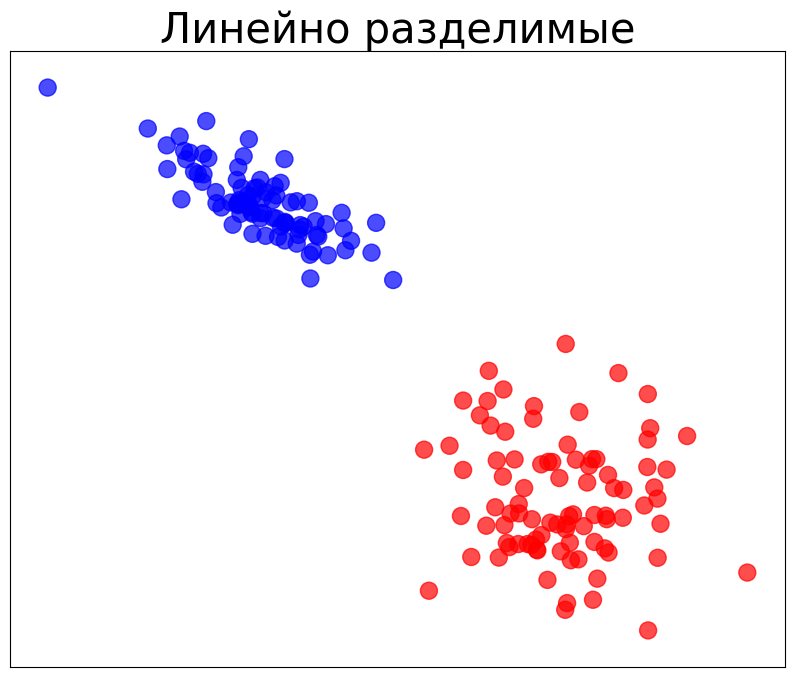

In [16]:
X, y = make_binary_clf(N, method = 'line', random_state=random_state) # начнем с простого случая Линейно-разделимых данных

# никогда не забываем хотя бы разделять на тренировочную и тестовую (валидационную)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# визуализируем
fig = plt.figure(figsize=(10, 8))
ax = plt.subplot(1, 1, 1)
plot_data(ax, (X, y), 'Линейно разделимые')